In [1]:
import os
from scTrace.pipeline import *

E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Run scTrace+ on LARRY

#### In vitro differentiation time course

In [2]:
dataSet = "Science20-Larry"
samName = "In vitro diff"
run_label = dataSet + "_" + samName

dataPath = "D:/Lineage-data/Science2020-Larry/In vitro differentiation time course/"

# In vitro differentiation time course
data_2 = sc.read(dataPath + 'D2_larry_scobj_down50.h5ad')
data_4 = sc.read(dataPath + 'D4_larry_scobj_down50.h5ad')
data_6 = sc.read(dataPath + 'D6_larry_scobj_down50.h5ad')

In [3]:
savePath = "D:/Lineage-data/Science2020-Larry/Results/" # + run_label + "/"

if not os.path.exists(savePath):
    os.makedirs(savePath)
    
colors = [["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#B3B3B3"],
          ["#43D9FE", "#E78AC3", "#FEC643", "#A6D854", "#FE6943", "#E5C494", "#33AEB1", "#FFEC1A"],
          ["#D5BB67", "#6ACC64", "#D65F5F", "#82C6E2", "#DC7EC0", "#4878D0"],
          ['#B5A2E0', '#F9B475', '#50C7CA', '#CF747A', '#63AFF0', '#8792AF', '#E0CB00']]

colors = [['#B5A2E0', '#F9B475', '#50C7CA', '#CF747A', '#63AFF0', '#8792AF', '#E0CB00', '#DC7EC0'],
          ["#43D9FE", "#E78AC3", "#FEC643", "#A6D854", "#FE6943", "#E5C494", "#33AEB1", "#FFEC1A", "#4878D0", '#984EA3', 
           '#CF747A', '#4DAF4A', '#C2C2C2'],
          ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#4878D0", "#6ACC64", "#82C6E2",
           "#D65F5F", "#43D9FE", '#B383C1', '#BC8967', "#B3B3B3"]]

In [4]:
all_data = [data_2, data_4, data_6]
print(data_2.shape)
print(data_4.shape)
print(data_6.shape)
all_names = ['Day2', 'Day4', 'Day6']

(14124, 4586)
(24249, 4586)
(27070, 4586)


In [5]:
time = 1

In [6]:
data_pre, data_pos = all_data[time:(time+2)]
pre_name, pos_name = all_names[time:(time+2)]

pre_colors = colors[time]
pos_colors = colors[time+1]

n_pre = data_pre.shape[0]
n_pos = data_pos.shape[0]
run_label_time = run_label + '-' + pre_name + '_' + pos_name
print(run_label_time)

Science20-Larry_In vitro diff-Day4_Day6


In [8]:
cross_sp_df, cross_lin_mat, barcodes_pre, barcodes_pos = prepareCrosstimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                                               lineage_identity='Clone',
                                                                               pre_name=pre_name, pos_name=pos_name,
                                                                               savePath=savePath, run_label_time=run_label_time)

Number of cells in the former time point:  24249
Number of cells with flow-out information:  5385
Flow-out density:  0.2220710132376593
Number of cells in the latter time point:  27070
Number of cells with flow-in information:  11215
Flow-in density:  0.4142962689323975
Generating mother-daughter similarity
0.8830743202212131 0.9004875688405469


In [7]:
sim_mat, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                 lineage_identity='Clone',
                                                 pre_name=pre_name, pos_name=pos_name,
                                                 savePath=savePath, run_label_time=run_label_time,
                                                 mode="pre")

Generating mother-daughter similarity (with-in timepoint)
0.9029274106052435 0.8868751101651757


#### Preparing side information Ku, Kv (run only-once)

In [ ]:
prepareSideInformation(data_pre=data_pre, data_pos=data_pos,
                       barcodes_pre=barcodes_pre, barcodes_pos=barcodes_pos,
                       savePath=savePath,
                       run_label_time=run_label_time,
                       single_inte_fraction=0.5)

#### Split training-validation sets for performance evaluation

In [ ]:
train_df, val_df = train_valid_split(cross_sp_df, ratio=0.2, type="stratified")

In [ ]:
hyper_dict, model = trainMF(train_df=train_df,
                            val_df=val_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True)

Loading pretrained model...


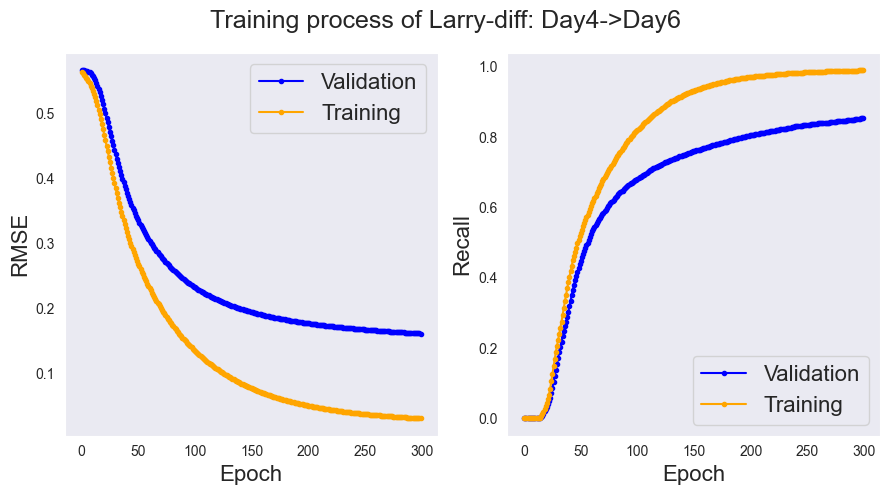

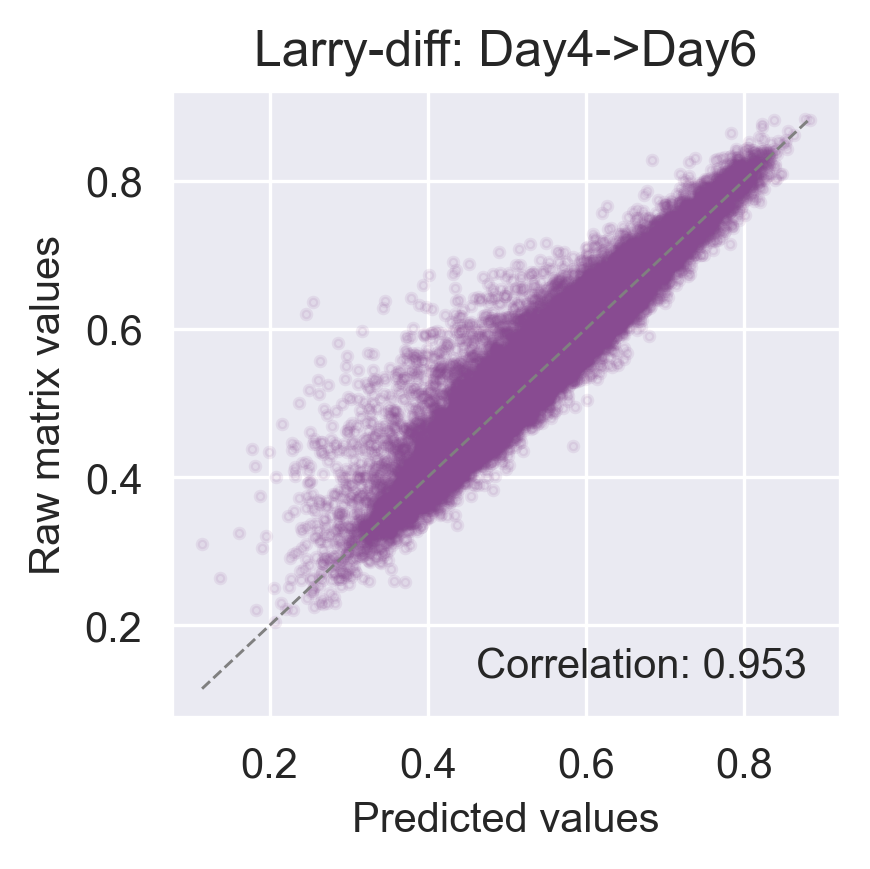

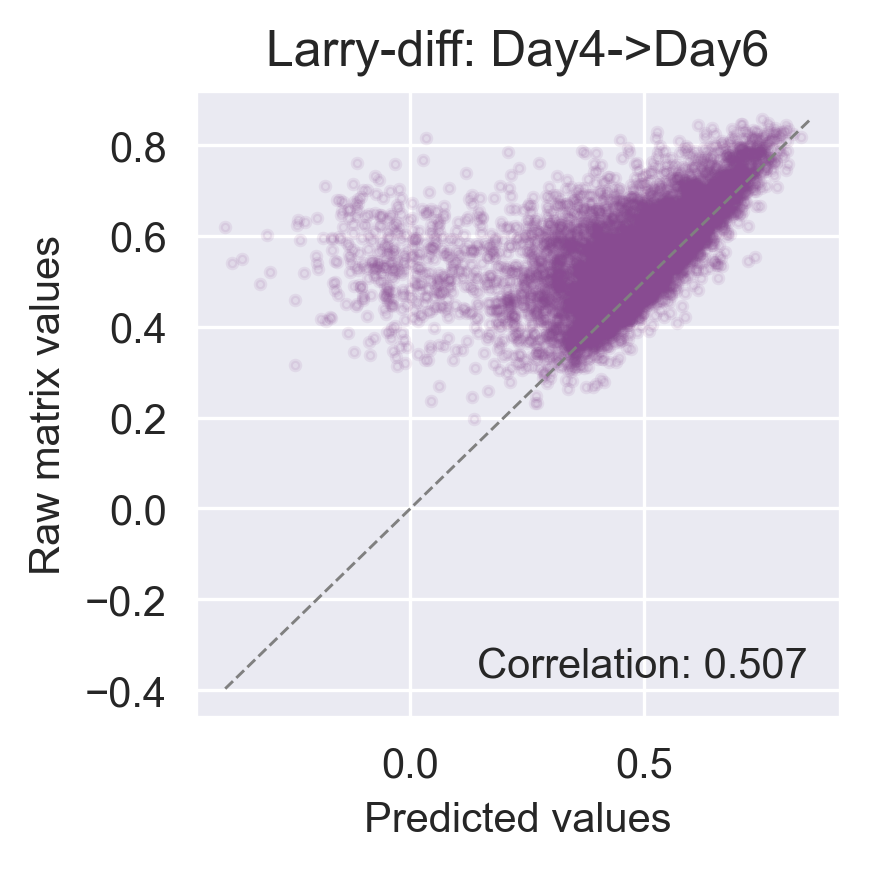

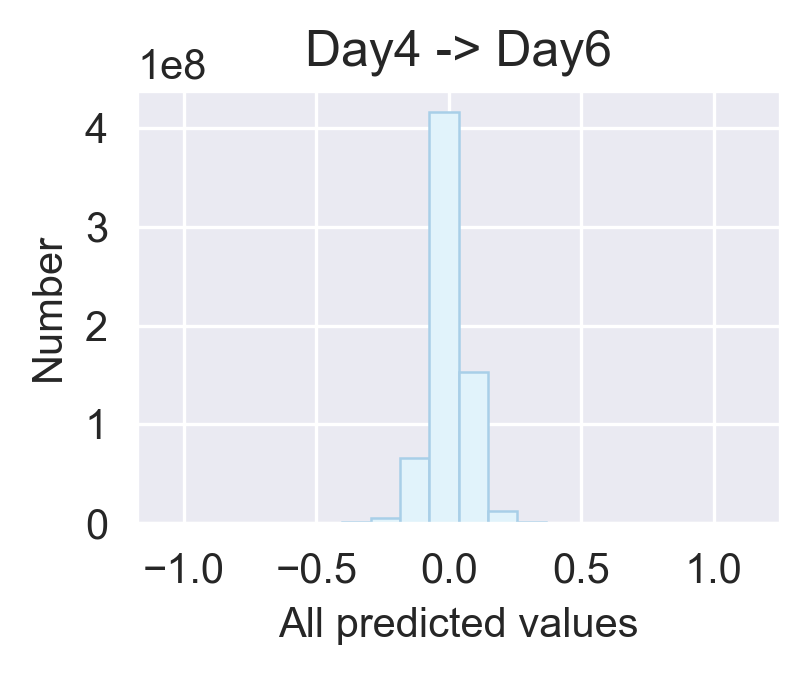

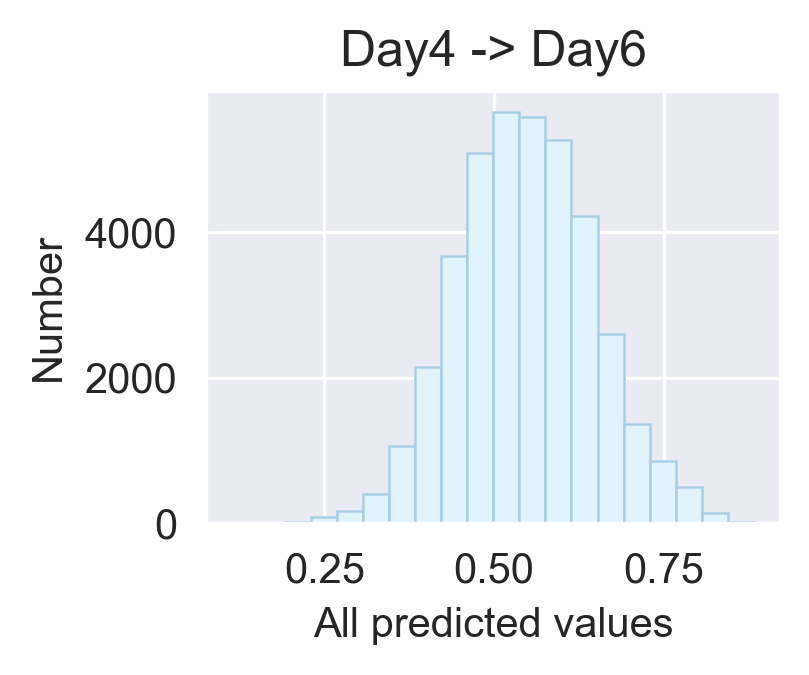

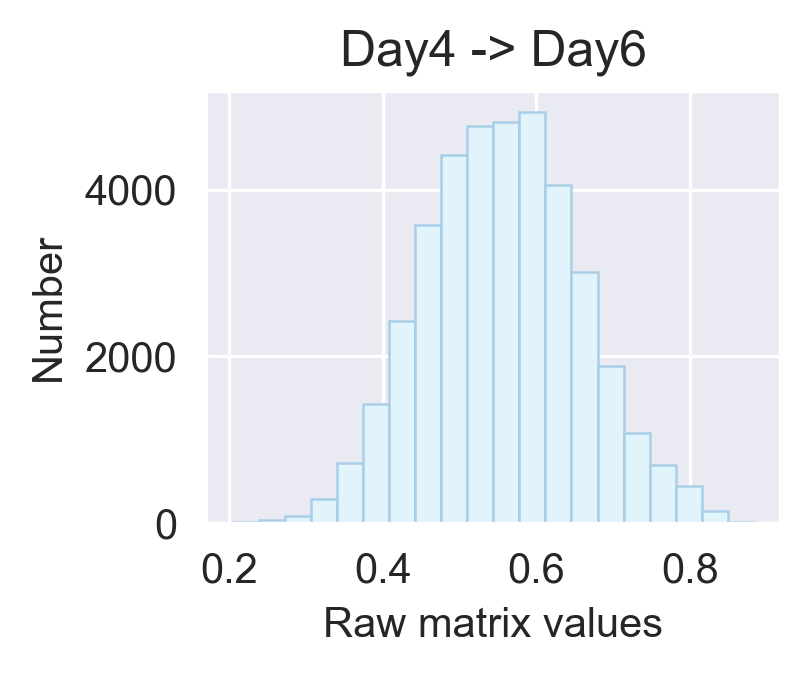

In [10]:
pred_mat, y_true, y_pred, complet_mat, corr, min_rmse, max_recall = predictMissingEntries(pre_name=pre_name,
                                                                                          pos_name=pos_name,
                                                                                          savePath=savePath,
                                                                                          run_label_time=run_label_time,
                                                                                          showName="Larry-diff",
                                                                                          threshold_positive=0.25)

#### Training on full dataset for downstream analysis

In [ ]:
hyper_dict, model = trainMF(train_df=cross_sp_df,
                            val_df=cross_sp_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True)

#### Load full model for downstream analysis

In [9]:
model = load_model(savePath + "model/" + run_label_time + '_model_full.pkl')

In [10]:
complet_mat = np.dot(model.p, model.q.T)

#### Automatically set the cut-off according to data distribution

In [11]:
basic_values = complet_mat.reshape((1, -1))[0][cross_lin_mat.reshape((1, -1))[0] > 0]
Q1, Q3 = np.percentile(basic_values, 25), np.percentile(basic_values, 75)
threshold = Q1 - 1.5 * (Q3 - Q1)
print(threshold)
complet_mat[complet_mat < threshold] = 0

0.27547700661918517


#### Clustering


## 1. Identify cell clusters and cell states ---------------------------


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scStateDynamics\scStateDynamics.py:37: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scobj, key_added='cluster', resolution=cls_res)


| - N_cells: [24249, 27070]
| - N_clusters: [6 6]
| - N_cliques: [810 787]
| - Saving figure: D:/Lineage-data/Science2020-Larry/Results/Science20-Larry_In vitro diff-Day4_Day6_Cell-PairUMAP.png


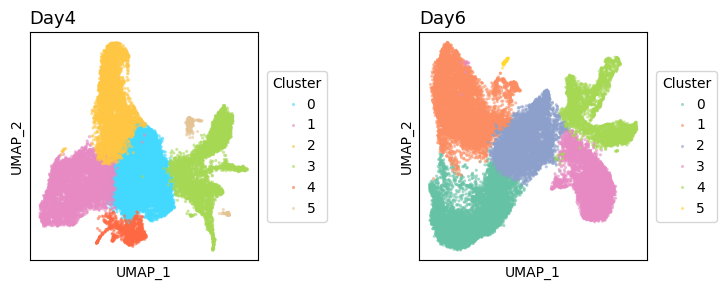

In [12]:
cls_res_all = [0.07, 0.07, 0.07, 0.07] # diff data, 0.05 for perturb data
cls_res_all = [0.1, 0.1, 0.1, 0.1] # diff data, 0.05 for perturb data
clq_res_all = [50, 50, 50, 50]

scd_obj = prepareScdobj(data_pre=data_pre, data_pos=data_pos,
                        time=time,
                        pre_name=pre_name, pos_name=pos_name,
                        cls_res_all=cls_res_all, clq_res_all=clq_res_all,
                        pre_colors=pre_colors, pos_colors=pos_colors,
                        savePath=savePath, run_label_time=run_label_time)

#### Cluster-level alignment (before and after enhancement)

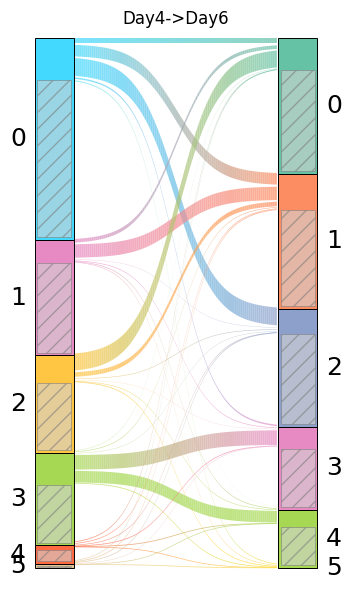

In [13]:
cls_lineage_mat, flow_info = visualizeLineageInfo(scd_obj=scd_obj,
                                                  cross_lin_mat=cross_lin_mat,
                                                  n_pre=n_pre, 
                                                  pre_colors=pre_colors, pos_colors=pos_colors,
                                                  pre_name=pre_name, pos_name=pos_name,
                                                  savePath=savePath,
                                                  run_label_time=run_label_time)

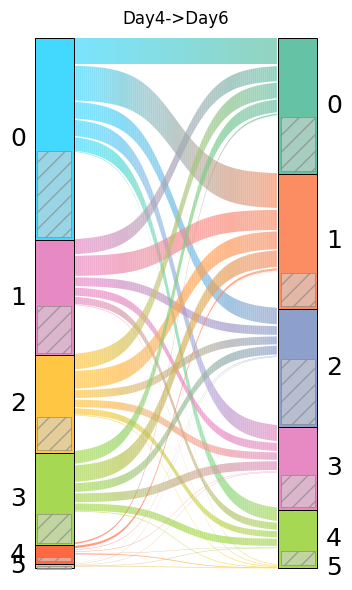

In [14]:
cls_trans_mat, flow_info_enhanced = visualizeEnhancedLineageInfo(scd_obj=scd_obj,
                                                                 complet_mat=complet_mat,
                                                                 n_pre=n_pre, 
                                                                 pre_colors=pre_colors, pos_colors=pos_colors,
                                                                 pre_name=pre_name, pos_name=pos_name,
                                                                 savePath=savePath,
                                                                 run_label_time=run_label_time)

#### Assign fate according to lineage information

Lineage_fate
Missing             18864
Neutrophil           1495
Undifferentiated     1360
Monocyte             1291
Baso                  803
Meg                   164
Mast                  160
Erythroid              68
Ccr7_DC                16
Lymphoid               13
Eos                    11
pDC                     4
Name: count, dtype: int64
Lineage_fate_label
Missing                                 18864
Undifferentiated -> Undifferentiated     1205
Undifferentiated -> Monocyte              811
Undifferentiated -> Neutrophil            736
Neutrophil -> Neutrophil                  629
Baso -> Baso                              512
Monocyte -> Monocyte                      407
Undifferentiated -> Baso                  265
Monocyte -> Neutrophil                    117
Undifferentiated -> Meg                   103
Mast -> Mast                               79
Neutrophil -> Monocyte                     67
Monocyte -> Undifferentiated               63
Neutrophil -> Undifferentiated  

E:\Lineage\Code\scTrace\scTrace\utils.py:678: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  same_label_count = sum(1 for j in neighbors if labels[j] == labels[i])
E:\Lineage\Code\scTrace\scTrace\utils.py:689: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_counts = Counter(labels[j] for j in neighbors)


Neighboring cell fate consistency: 0.5900 Neighboring cell fate randomness: 0.5242


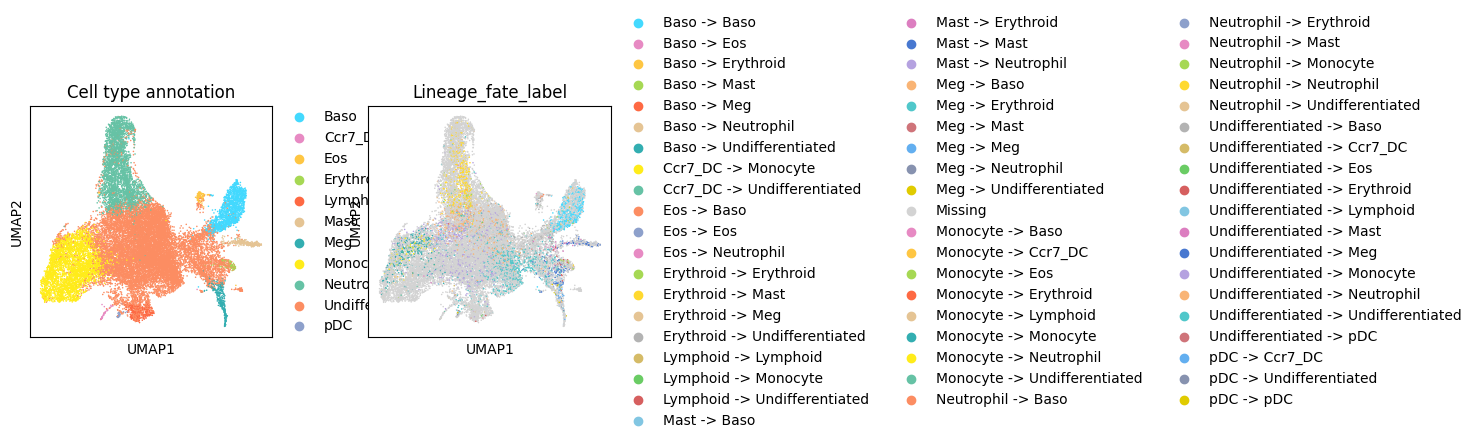

In [15]:
scd_obj, metrics = assignLineageInfo(scd_obj,
                                     cross_lin_mat,
                                     savePath,
                                     run_label_time,
                                     sel_cluster_name="Cell type annotation")

100%|██████████| 24249/24249 [00:14<00:00, 1698.20it/s]
E:\Lineage\Code\scTrace\scTrace\pipeline.py:281: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_pre.obs[enhanced_fate_colname][i] == "Missing":
E:\Lineage\Code\scTrace\scTrace\pipeline.py:283: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = val

Ratio of newly added fate clusters: 0.2195


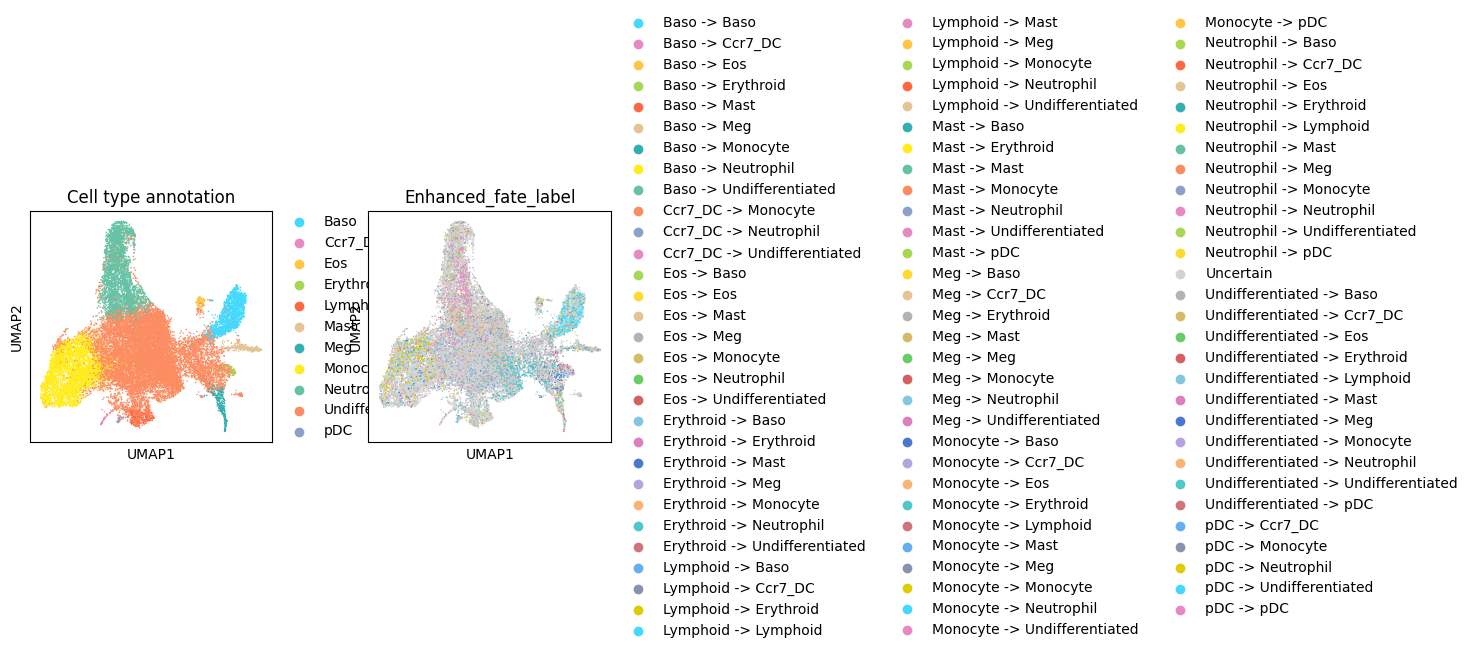

In [16]:
adata_pre, enhance_rate = enhanceFate(scd_obj,
                                      complet_mat,
                                      savePath,
                                      run_label_time,
                                      cluster_name='Cell type annotation')

#### Run DEGs (before and after enhancement)

#### Select fates (Recommend)

In [19]:
sel_cls = 'Undifferentiated'
sel_fates = ['Undifferentiated -> Undifferentiated', 'Undifferentiated -> Monocyte']
cls_colname, fate_colname = 'Cell type annotation', 'Lineage_fate_label'
lt_sub_expr, lt_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                               saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')
cls_colname, fate_colname = 'Cell type annotation', 'Enhanced_fate_label'
eh_sub_expr, eh_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                            saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')

['Undifferentiated -> Monocyte' 'Undifferentiated -> Undifferentiated'] [ 811 1205]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['Undifferentiated -> Monocyte' 'Undifferentiated -> Undifferentiated'] [1495 1755]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


#### All fates (1 v.s. rest)

In [20]:
all_de_df_lt = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                   sel_cluster_name="Cell type annotation",
                                   fate_colname='Lineage_fate',
                                   special_case="Missing")
all_de_df_enhanced = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                         sel_cluster_name="Cell type annotation",
                                         fate_colname='Enhanced_fate',
                                         special_case="Uncertain")

['Baso' 'Eos' 'Erythroid' 'Mast' 'Meg' 'Neutrophil' 'Undifferentiated'] [512   2  12  21   1   3   5]
['Baso' 'Eos' 'Erythroid' 'Mast' 'Neutrophil' 'Undifferentiated'] [512   2  12  21   3   5]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Monocyte' 'Undifferentiated'] [1 1]
[] []
division by zero
['Baso' 'Eos' 'Neutrophil'] [7 2 1]
['Baso' 'Eos'] [7 2]
(0, 7)
(0, 7)
['Erythroid' 'Mast' 'Meg' 'Undifferentiated'] [14  1  7  1]
['Erythroid' 'Meg'] [14  7]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
['Lymphoid' 'Monocyte' 'Undifferentiated'] [4 5 7]
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Erythroid' 'Mast' 'Neutrophil'] [ 2  2 79  3]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Erythroid' 'Mast' 'Meg' 'Neutrophil' 'Undifferentiated'] [ 1  4  1 53  6 16]
['Erythroid' 'Meg' 'Neutrophil' 'Undifferentiated'] [ 4 53  6 16]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Monocyte' 'Neutrophil'
 'Undifferentiated'] [  3  11   1   4   2 407 117  63]
['Baso' 'Ccr7_DC' 'Erythroid' 'Lymphoid' 'Monocyte' 'Neutrophil'
 'Undifferentiated'] [  3  11   4   2 407 117  63]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(5, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 7)
['Baso' 'Erythroid' 'Mast' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [ 13   1   7  67 629  58]
['Baso' 'Mast' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [ 13   7  67 629  58]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(1, 7)
(0, 7)
(2, 7)
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated' 'pDC'] [ 265    4    6   31    7   51  103  811  736 1205    1]
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated'] [ 265    4    6   31    7   51  103  811  736 1205]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(87, 7)
(0, 7)
(0, 7)
(17, 7)
(0, 7)
(26, 7)
(126, 7)
(392, 7)
(1016, 7)
(114, 7)
['Ccr7_DC' 'Undifferentiated' 'pDC'] [1 4 3]
['Undifferentiated' 'pDC'] [4 3]
(0, 7)
(0, 7)


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Mast' 'Meg' 'Monocyte' 'Neutrophil'
 'Undifferentiated'] [540   6   8  16  23  15  62  51  57]
(3, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Monocyte' 'Neutrophil' 'Undifferentiated'] [5 1 1]
['Monocyte'] [5]
(0, 7)
['Baso' 'Eos' 'Mast' 'Meg' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [8 4 1 1 5 7 3]
['Baso' 'Eos' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [8 4 5 7 3]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:358: RuntimeWarning: invalid value encountered in divide
  scores[group_index, :] = (
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Erythroid' 'Mast' 'Meg' 'Monocyte' 'Neutrophil'
 'Undifferentiated'] [ 4 16  2  7  5  1  3]
['Baso' 'Erythroid' 'Mast' 'Meg' 'Monocyte' 'Undifferentiated'] [ 4 16  2  7  5  3]
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated'] [ 8  1  2  6  1  1 25 11 22]
['Baso' 'Erythroid' 'Lymphoid' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [ 8  2  6 25 11 22]
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Erythroid' 'Mast' 'Monocyte' 'Neutrophil' 'Undifferentiated'
 'pDC'] [ 9  2 79 15 17 13  1]
['Baso' 'Erythroid' 'Mast' 'Monocyte' 'Neutrophil' 'Undifferentiated'] [ 9  2 79 15 17 13]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(1, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Erythroid' 'Mast' 'Meg' 'Monocyte' 'Neutrophil'
 'Undifferentiated'] [ 4  2  5  2 54 16 15 30]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated' 'pDC'] [ 96  33  15  19   6  15  28 597 254 234   1]
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated'] [ 96  33  15  19   6  15  28 597 254 234]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(1, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated' 'pDC'] [ 99  11  10  13   1  17  22 243 767 207   2]
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Mast' 'Meg' 'Monocyte' 'Neutrophil'
 'Undifferentiated' 'pDC'] [ 99  11  10  13  17  22 243 767 207   2]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(1, 7)
(106, 7)
(1, 7)
(0, 7)
['Baso' 'Ccr7_DC' 'Eos' 'Erythroid' 'Lymphoid' 'Mast' 'Meg' 'Monocyte'
 'Neutrophil' 'Undifferentiated' 'pDC'] [ 613   82   53   79   19  102  210 1495 1214 1755    7]


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


(26, 7)
(0, 7)
(0, 7)
(0, 7)
(0, 7)
(6, 7)
(39, 7)
(206, 7)
(497, 7)
(93, 7)
(0, 7)
['Ccr7_DC' 'Monocyte' 'Neutrophil' 'Undifferentiated' 'pDC'] [1 2 2 6 3]
['Monocyte' 'Neutrophil' 'Undifferentiated' 'pDC'] [2 2 6 3]
(0, 7)
(0, 7)
(0, 7)
(0, 7)


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scanpy\tools\_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


#### Save results

In [21]:
pre_df = adata_pre.obs[['cluster', 'Cell type annotation', 'Lineage_fate', 'Lineage_fate_label', 'Enhanced_fate', 'Enhanced_fate_label']]
pre_df.to_csv(savePath + run_label_time + ' - res_anno' + '_'  + str(threshold) + '.txt', sep = '\t')

#### (1-Missing rate) of cell fates

In [22]:
print(sum(pre_df['Lineage_fate_label'] != 'Missing') / pre_df.shape[0])
print(sum(pre_df['Enhanced_fate_label'] != 'Uncertain') / pre_df.shape[0])

0.2220710132376593
0.39284094189451113


#### Inference accuracy

In [23]:
correct_fates = ['Undifferentiated -> Undifferentiated', 'Undifferentiated -> Monocyte', 'Undifferentiated -> Neutrophil', 
                 'Neutrophil -> Neutrophil', 'Baso -> Baso', 'Monocyte -> Monocyte', 'Undifferentiated -> Baso', 
                 'Undifferentiated -> Meg', 'Mast -> Mast', 'Meg -> Meg', 'Undifferentiated -> Mast', 'Undifferentiated -> Erythroid',
                 'Erythroid -> Erythroid', 'Undifferentiated -> Lymphoid', 'Undifferentiated -> Ccr7_DC', 'Lymphoid -> Lymphoid', 
                 'pDC -> pDC', 'Eos -> Eos', 'Undifferentiated -> pDC']
print(sum(pre_df['Enhanced_fate_label'].isin(correct_fates)) / sum(pre_df['Enhanced_fate_label'] != 'Uncertain'))

0.8022254881377283
